In [137]:
import numpy as np
import pandas as pd
import cvxpy as cp 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import true_positive_rate
from fairlearn.reductions import DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import math
import scipy.stats as stats
import models as md
import datasets as ds
import utils as ut 
import seaborn as sns

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synthetic Data

In [138]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

n = 1000
d = 2
x = np.random.randn(n, d) 

g1 = np.sqrt(0.3)*x[:, 1] + np.sqrt(0.8)*x[:, 0] + 0.01*np.random.randn(n) 
g2 = -np.sqrt(0.01)*x[:, 0] + np.sqrt(0.9)*x[:, 1] + 0.01*np.random.randn(n)
g3 = np.sqrt(0.15)*x[:, 0] + np.sqrt(0.85)*x[:, 1] + 0.01*np.random.randn(n)
g = np.sqrt(0.7)*x[:, 1] + np.sqrt(0.3)*x[:, 0]
b = np.asarray([9, 1])
y = sigmoid(x@b) + 0.1*np.random.randn(n)# should be between 0 and 1

In [139]:
data_df = pd.DataFrame() 
data_df['x1'] = x[:, 0]
data_df['x2'] = x[:, 1]
data_df['g1_c'] = g1
data_df['g2_c'] = g2
data_df['g3_c'] = g3
data_df['g_c'] = g
data_df['g1'] = (g1 > 0).astype(int)
data_df['g2'] = (g2 > 0).astype(int)
data_df['g3'] = (g3 > 0).astype(int)
data_df['g'] = (g > 0).astype(int)
data_df['y_c'] = y
data_df['y'] = (y > 0.5).astype(int)

In [140]:
# Original Covariance
for group in ['g1_c', 'g2_c', 'g3_c']: 
    print(f'cov(y, {group}) : {ut.emp_cov(data_df["y"], data_df[group]):.2f} '
          f'var({group}): {np.var(data_df[group]):.2f}, '
          f'corr(y, {group}) {stats.pearsonr(data_df["y"], data_df[group])[0]:.2f} ')
    print(f'cov(g, {group}) : {ut.emp_cov(data_df["g"], data_df[group]):.2f} '
          f'var({group}): {np.var(data_df[group]):.2f}, '
          f'corr(g, {group}) {stats.pearsonr(data_df["g"], data_df[group])[0]:.2f} ')
print(f'cov(g, y) {ut.emp_cov(data_df["g"], data_df["y"]):.2f}')
print(f'corr(g, y) {stats.pearsonr(data_df["g"], data_df["y"])[0]:.2f} ')
print(f'var(y) {np.var(data_df["y"])}')
print(f'var(g) {np.var(data_df["g_c"])}')

cov(y, g1_c) : 0.37 var(g1_c): 1.08, corr(y, g1_c) 0.72 
cov(g, g1_c) : 0.38 var(g1_c): 1.08, corr(g, g1_c) 0.72 
cov(y, g2_c) : 0.01 var(g2_c): 0.92, corr(y, g2_c) 0.01 
cov(g, g2_c) : 0.30 var(g2_c): 0.92, corr(g, g2_c) 0.63 
cov(y, g3_c) : 0.19 var(g3_c): 1.01, corr(y, g3_c) 0.39 
cov(g, g3_c) : 0.40 var(g3_c): 1.01, corr(g, g3_c) 0.79 
cov(g, y) 0.11
corr(g, y) 0.45 
var(y) 0.24996399999999994
var(g) 1.0061339741162116


In [141]:
frac = 0.7
train_ind = np.random.choice([True, False], size=len(data_df), p=[frac, 1-frac])
data_df['train'] = train_ind

x_train = data_df[data_df['train']==True][['x1', 'x2']].values
y_train = data_df[data_df['train']==True]['y'].values
x_test = data_df[data_df['train']==False][['x1', 'x2']].values
y_test = data_df[data_df['train']==False]['y'].values
g1_train = data_df[data_df['train']==True]['g1'].values
g1_test = data_df[data_df['train']==False]['g1'].values
g2_train = data_df[data_df['train']==True]['g2'].values
g2_test = data_df[data_df['train']==False]['g2'].values
g_train = data_df[data_df['train']==True]['g'].values
g_test = data_df[data_df['train']==False]['g'].values

In [143]:
models = {}
clf = LogisticRegression()
clf.fit(x_train, y_train)

pg_clf = LogisticRegression() 
pg_clf.fit(x_train, g1_train)
# add pg data for plotting
data_df['pg1'] = pg_clf.predict_proba(data_df[['x1', 'x2']].values)[:, 1]

pg2_clf = LogisticRegression() 
pg2_clf.fit(x_train, g2_train)
data_df['pg2'] = pg2_clf.predict_proba(data_df[['x1', 'x2']].values)[:, 1]


results = ut.results_summary(p=clf.predict_proba(x_test)[:, 1], 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)

models['Base'] = {'acc': results['accuracy'], 
                  'coeff':clf.coef_[0], 
                  'intercept':clf.intercept_}

print(results)

{'accuracy': 0.9830508474576272, 'cov(p, pg1)': 0.16300546916137015, 'cov(p, pg2)': -0.003140426344936055, 'DP': 0.423600257423922, 'cov(p, pg1 |y=1)': 0.011166959006449028, 'cov(p, pg2 |y=1)': -0.013576919781645286, 'EO': 0.013308763308763294}


In [146]:
# DP Continuous Discrete Attributes
postprocess_est = ThresholdOptimizer(
    estimator=clf, 
    constraints="demographic_parity", 
    objective='accuracy_score', 
    predict_method="predict", 
    flip =True
)

postprocess_est.fit(X=x_train, y=y_train, sensitive_features=g_train)

p_train = postprocess_est.predict(x_train, sensitive_features=g_train)

p_clf = LogisticRegression()
p_clf.fit(x_train, p_train)

results = ut.results_summary(p=postprocess_est.predict(x_test, sensitive_features=g_test), 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)

models['DP wrt g'] = {'acc': results['accuracy'], 
                      'coeff': p_clf.coef_[0], 
                      'intercept':p_clf.intercept_}

print(results)

{'accuracy': 0.7389830508474576, 'cov(p, pg1)': 0.06064136493409227, 'cov(p, pg2)': -0.04422911423152387, 'DP': 0.059621219086145094, 'cov(p, pg1 |y=1)': -0.05530218752260345, 'cov(p, pg2 |y=1)': -0.09043909761166072, 'EO': 0.661957411957412}


In [148]:
for name, g_clf in zip(['DP wrt Pg1', 'DP wrt Pg2'], [pg_clf, pg2_clf]): 
    c_post_processed = md.MACov(base_clf=clf, pg_clf=g_clf)
    md.fit_pg_cont(p_x=x_train, 
                   base_clf=c_post_processed, 
                   pg_clf=g_clf, 
                   alpha=1e-4)
    p = c_post_processed.predict_proba_1d(x_train)

    p_clf = LogisticRegression()
    p_clf.fit(x_train, p>0.5)
    results = ut.results_summary(p=c_post_processed.predict_proba(x_test)[:, 1],
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)
    print(name, results)
    
    
    models[name] = {'acc': results['accuracy'], 
                    'coeff': p_clf.coef_[0], 
                    'intercept':p_clf.intercept_}

0 0.1592319135752638
1 0.128147888254428
2 0.10386398307945645
3 0.08460858787890858
4 0.06925012874885456
5 0.05692013874722249
6 0.046862962108324545
7 0.03867313306387604
8 0.03198317160366506
9 0.026488633246615476
10 0.0219555258882667
11 0.01821045486677847
12 0.015141723232018218
13 0.012594459076792741
14 0.010490068040156895
15 0.008752399120686738
16 0.00731402040485318
17 0.006113420139292613
18 0.005109886944536205
19 0.004271086231767292
20 0.003571535886618384
21 0.002989325872684949
22 0.0025029503997354564
23 0.002095739940036361
24 0.0017547794381893571
25 0.0014692905440542076
26 0.0012302484607835658
27 0.0010303124016475785
28 0.0008637336170134401
29 0.0007244880547978608
30 0.0006076907639182698
31 0.0005097227788726023
32 0.0004275485604328699
33 0.0003586219394246602
34 0.00030080722364377466
35 0.00025231302340688255
36 0.00021163674522205544
37 0.00017751803420213916
38 0.00014889972170913722
39 0.00012489506896979518
40 0.00010476029151646696
41 8.78715130160

In [149]:
c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=[pg_clf, pg2_clf])
md.fit_dp_pg_multi(x=x_train,  
                   multi_clf=c_post_processed, 
                   alpha=1e-5, 
                  max_iter=30)

p = c_post_processed.predict_proba_1d(x_train)


p_clf = LogisticRegression()
p_clf.fit(x_train, p>0.5)
results = ut.results_summary(p=c_post_processed.predict_proba(x_test)[:, 1],
                        pg1=pg_clf, 
                        pg2=pg2_clf, 
                        x=x_test, 
                        y=y_test, 
                        g=g_test)
print(name, results)

100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 238.45it/s]

DP wrt Pg2 {'accuracy': 0.5254237288135594, 'cov(p, pg1)': -0.00041766544887966397, 'cov(p, pg2)': -0.0013726314920972746, 'DP': 0.10273972602739725, 'cov(p, pg1 |y=1)': -0.04455048646634619, 'cov(p, pg2 |y=1)': -0.017785001580394866, 'EO': 0.3409090909090909}


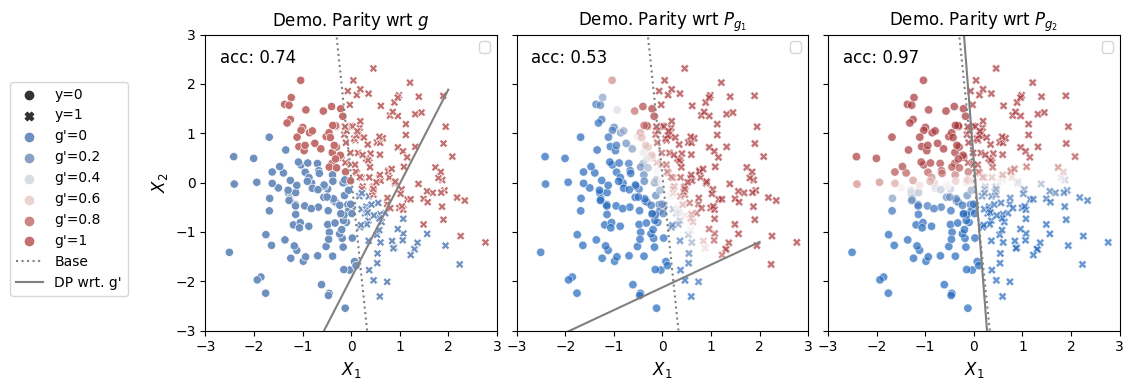

In [151]:
c1 = sns.color_palette("vlag")[0]
c2 = sns.color_palette("vlag")[-1]
custom_palette = [c1, c2]

# Create a list to store legend handles and labels
legend_handles = []
legend_labels = []
scatter_legend_handles = []
scatter_legend_labels = []

fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(10, 4)) 
plot_df = data_df[data_df['train']==False]
scatter_legend = sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='g', style='y', ax=axes[0], palette=custom_palette)

scatter_legend_handles.extend(scatter_legend.legend_.legendHandles)
scatter_legend_labels.extend(scatter_legend.legend_.get_texts())

# demographic parity - two groups
for key, l in zip(['Base', 'DP wrt g'], [':', '-']): 

    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    line, = axes[0].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    if line not in legend_handles:
        legend_handles.append(line)
        legend_labels.append(f"{key}")
axes[0].legend([])
axes[0].set_xlabel(r"$X_1$", fontsize=12)
axes[0].set_ylabel(r"$X_2$", fontsize=12)
axes[0].text(0.05, 0.95, f"acc: {acc:.2f}", transform=axes[0].transAxes, fontsize=12, va='top', ha='left')        
axes[0].set_title(r"Demo. Parity wrt $g$")

scatter_legend = sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='pg1', style='y', alpha=0.7, ax=axes[1], palette='vlag')
scatter_legend_handles.extend(scatter_legend.legend_.legendHandles)
scatter_legend_labels.extend(scatter_legend.legend_.get_texts())

for key, l in zip(['Base', 'DP wrt Pg1'], [':', '-']): 
    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    line, = axes[1].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    if line not in legend_handles:
        legend_handles.append(line)
        legend_labels.append(f"{key}")
axes[1].legend([])
axes[1].set_xlabel(r"$X_1$", fontsize=12)
axes[1].text(0.05, 0.95, f"acc: {acc:.2f}", transform=axes[1].transAxes, fontsize=12, va='top', ha='left')        
axes[1].set_title(r"Demo. Parity wrt $P_{g_1}$")


scatter_legend = sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='pg2', style='y', alpha=0.7, ax=axes[2], palette='vlag')

for key, l in zip(['Base', 'DP wrt Pg2'], [':', '-']): 
    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    line, = axes[2].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    axes[2].set_xlabel(r"$X_1$", fontsize=12)
    axes[2].set_xlim(-3, 3)
    axes[2].set_ylim(-3, 3)
    axes[2].legend([])
axes[2].text(0.05, 0.95, f"acc: {acc:.2f}", transform=axes[2].transAxes, fontsize=12, va='top', ha='left')
    
axes[2].set_title(r"Demo. Parity wrt $P_{g_2}$")

# Combine scatter plot and line plot legend handles and labels
scatter_ind = [4, 5, 1, 7, 8, 9, 10, 2]
scatter_labels = ["y=0", "y=1", "g'=0", "g'=0.2", "g'=0.4", "g'=0.6", "g'=0.8", "g'=1"]

legend_handles = list(np.asarray(scatter_legend_handles)[scatter_ind]) + legend_handles[:2]
legend_labels = scatter_labels + legend_labels[:2]
legend_labels[-1] = "DP wrt. g'"

# Add a combined legend for all subplots
figlegend = plt.figlegend(legend_handles, legend_labels, bbox_to_anchor=(0, 0.8))


fig.tight_layout() 
fig.savefig("synthetic_dp.pdf", bbox_inches='tight')

In [152]:
# Multi Accuracy
g_clf = pg_clf
pg = g_clf.predict_proba(x_train)[:, 1]
cov = ut.emp_cov(pg, y_train)
p = clf.predict(x_train)
curr_cov = ut.emp_cov(pg, p)
print(f"baseline cov {cov}, curr cov: {curr_cov}")

c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=[g_clf])
md.fit_ma_pg_multi(p_x=x_train, 
                   y=y_train,
                   multi_clf=c_post_processed, 
                   alpha=1e-5)

p = c_post_processed.predict_proba_1d(x_test)
p_acc = accuracy_score(y_test, p>0.5)

new_cov_d = ut.emp_cov(p>0.5, g_clf.predict_proba(x_test)[:, 1])
new_cov_c = ut.emp_cov(p, g_clf.predict_proba(x_test)[:, 1])

print(f"clf acc: {p_acc:.3f} new_cov_c: {new_cov_d:.3f}")

# p_clf = LogisticRegression()
# p_clf.fit(x_test, p>0.5)
# models[name] = {'acc': p_acc, 'coeff': p_clf.coef_[0], 'intercept':p_clf.intercept_}


100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1376.99it/s]

baseline cov 0.16645827382462117, curr cov: 0.16589483275635167
clf acc: 0.983 new_cov_c: 0.174


In [153]:
postprocess_est = ThresholdOptimizer(
    estimator=clf, 
    constraints="true_positive_rate_parity", 
    objective='accuracy_score', 
    predict_method="predict", 
    flip =True
)

postprocess_est.fit(X=x_train, y=y_train, sensitive_features=g_train)

p_train = postprocess_est.predict(x_train, sensitive_features=g_train)

p_clf = LogisticRegression()
p_clf.fit(x_train, p_train)

results = ut.results_summary(p=postprocess_est.predict(x_test, sensitive_features=g_test), 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)
results

{'accuracy': 0.9830508474576272,
 'cov(p, pg1)': 0.17430765323418773,
 'cov(p, pg2)': 0.0007843635926050443,
 'DP': 0.423600257423922,
 'cov(p, pg1 |y=1)': 0.0037844138029290734,
 'cov(p, pg2 |y=1)': -0.010044304971157242,
 'EO': 0.013308763308763294}

In [154]:
# Equal Opportunity
eo_clf = md.EOClf(base_clf=clf, pg_clf_list=[pg2_clf])
eo_clf.fit_exact(x=x_train, y=y_train)



p = clf.predict_proba(x_train)[:, 1]
pg = pg_clf.predict_proba(x_train)[:, 1]

print(f"prev cov {ut.eo_metric(y_pred=p, y_true=y_train, pg=pg):.2f}")

p = eo_clf.predict_proba_1d(x_train)
print(f"new cov {ut.eo_metric(y_pred=p, y_true=y_train, pg=pg):.2f}")

results = ut.results_summary(p=eo_clf.predict_proba(x_test)[:, 1], 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)
results


prev cov 0.02
new cov 0.02


{'accuracy': 0.9830508474576272,
 'cov(p, pg1)': 0.16244383238223592,
 'cov(p, pg2)': -0.0023498378036868697,
 'DP': 0.423600257423922,
 'cov(p, pg1 |y=1)': 0.011488613316758338,
 'cov(p, pg2 |y=1)': -0.012117511739577088,
 'EO': 0.013308763308763294}